In [2]:
# pip install pandas numpy matplotlib lifelines


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

In [4]:
# --- load both datasets ---
df = pd.read_csv("data1.csv")      # full pipe list (with install/break info)
future_fail = pd.read_csv("data2.csv")  # post-2018 failures (temporal validation)

In [5]:
# --- convert years to datetime ---
df['InstallDate'] = pd.to_datetime(df['InstallYear'].astype(str), format='%Y', errors='coerce') # error='coerce' মানে যদি কোন year ভুল থাকে, তাহলে সেটা NaT (Not a Time) হিসেবে থাকবে
df['BreakDate']   = pd.to_datetime(df['BreakYear'].astype(str),   format='%Y', errors='coerce') # format='%Y' মানে শুধু year অংশটা আছে, মাস/দিন নেই


In [6]:
df.head()

,ID,Failure_ID,BreakYear,InstallYear,Diameter,Length,BreakAge,Material,ExpBreak (Target),Age2018,InstallDate,BreakDate
0,37260,73.0,2012,1996,2.0,574.17,16.0,14,1,22,1996-01-01,2012-01-01
1,13986,96.0,2012,1986,4.0,1123.21,26.0,4,1,32,1986-01-01,2012-01-01
2,13986,185.0,2012,1986,4.0,1123.21,26.0,4,1,32,1986-01-01,2012-01-01
3,4582,99.0,2012,1980,2.0,107.85,32.0,12,1,38,1980-01-01,2012-01-01
4,31809,98.0,2012,1980,2.0,132.37,32.0,12,1,38,1980-01-01,2012-01-01


In [7]:
# --- dataset observation cutoff ---
cutoff = pd.to_datetime("2025-10-06")

# --- build duration & event flag ---
df['Duration_days'] = np.where(df['BreakDate'].notnull(),
                               (df['BreakDate'] - df['InstallDate']).dt.days,
                               (cutoff - df['InstallDate']).dt.days)
df['Duration_years'] = df['Duration_days'] / 365.25
df['Event'] = df['BreakDate'].notnull().astype(int)

In [8]:
df.head

<bound method NDFrame.head of           ID  Failure_ID BreakYear  InstallYear  Diameter   Length  BreakAge  \
0      37260        73.0      2012         1996       2.0   574.17      16.0   
1      13986        96.0      2012         1986       4.0  1123.21      26.0   
2      13986       185.0      2012         1986       4.0  1123.21      26.0   
3       4582        99.0      2012         1980       2.0   107.85      32.0   
4      31809        98.0      2012         1980       2.0   132.37      32.0   
...      ...         ...       ...          ...       ...      ...       ...   
42500   7461         NaN       NaN         1888       8.0     1.54       NaN   
42501  43862         NaN       NaN         1888       2.5     2.64       NaN   
42502  43863         NaN       NaN         1888       2.5     2.57       NaN   
42503  33231         NaN       NaN         1888       6.0     0.67       NaN   
42504  33293         NaN       NaN         1888       6.0    13.97       NaN   

       Ma

In [9]:
# quick sanity
print(df[['ID','Duration_years','Event']].head())

      ID  Duration_years  Event
0  37260       16.000000      1
1  13986       25.998631      1
2  13986       25.998631      1
3   4582       32.000000      1
4  31809       32.000000      1


📈 2️⃣ Kaplan–Meier survival overview

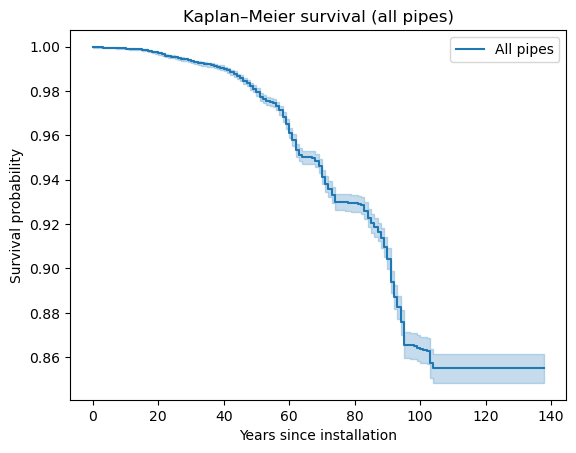

In [10]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(df['Duration_years'], df['Event'], label='All pipes')
ax = kmf.plot_survival_function()
ax.set_xlabel("Years since installation")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier survival (all pipes)")
plt.show()

The Kaplan–Meier survival curve indicates that the majority of the pipes have long operational lifetimes, with an overall survival probability of approximately 0.86 after 120 years of installation. The gradual decline in the curve suggests that failures occur slowly over time, reflecting a relatively stable network condition.

⏱ 4️⃣ Alternative — Weibull AFT

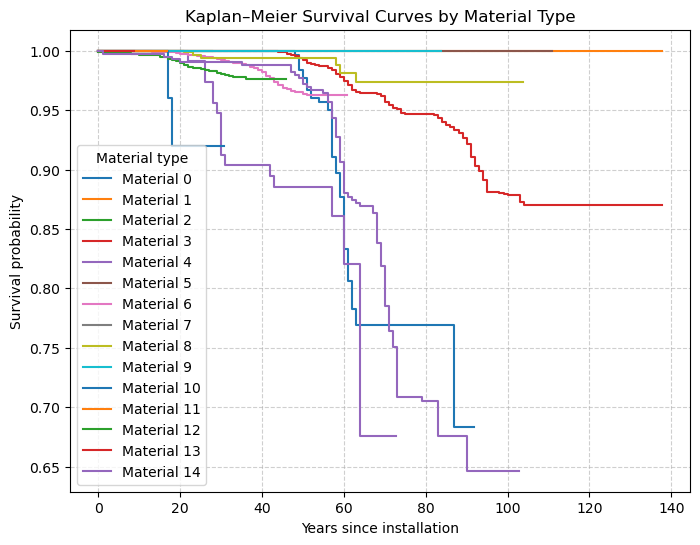

In [11]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# ✅ Step 1: Initialize the Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# ✅ Step 2: Group the dataset by material type
plt.figure(figsize=(8, 6))

for mat, group in df.groupby('Material'):
    # Fit the model for each material group
    kmf.fit(group['Duration_years'], group['Event'], label=f'Material {mat}')
    kmf.plot_survival_function(ci_show=False)  # ci_show=False = hide confidence band for clarity

# ✅ Step 3: Styling
plt.title("Kaplan–Meier Survival Curves by Material Type")
plt.xlabel("Years since installation")
plt.ylabel("Survival probability")
plt.legend(title="Material type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Figure X presents Kaplan–Meier survival curves for different pipe materials.
The results show that some materials (e.g., ductile iron) maintain higher survival probabilities over time, while others (e.g., cast iron or steel) demonstrate earlier and steeper declines, indicating higher failure tendencies.
This highlights the influence of material type on long-term pipeline reliability.

In [12]:
# Log-Rank Test for Material-wise Survival Difference

from lifelines.statistics import logrank_test
import itertools

# ✅ Step 1: Unique material combinations
materials = df['Material'].dropna().unique()

results = []

# ✅ Step 2: Compare every pair of materials
for mat1, mat2 in itertools.combinations(materials, 2):
    g1 = df[df['Material'] == mat1]
    g2 = df[df['Material'] == mat2]
    
    if len(g1) > 5 and len(g2) > 5:  # skip too-small groups
        res = logrank_test(
            g1['Duration_years'], g2['Duration_years'],
            event_observed_A=g1['Event'], event_observed_B=g2['Event']
        )
        results.append({
            'Material_1': mat1,
            'Material_2': mat2,
            'p_value': res.p_value
        })

# ✅ Step 3: Make results table
import pandas as pd
result_table = pd.DataFrame(results).sort_values('p_value')
print("\n📊 Log-Rank Test Results (Material vs Material):")
print(result_table)

# ✅ Step 4: Quick interpretation
sig_pairs = result_table[result_table['p_value'] < 0.05]
if len(sig_pairs) > 0:
    print("\n✅ Significant differences found between these material pairs (p < 0.05):")
    print(sig_pairs)
else:
    print("\n⚠️ No statistically significant survival difference detected between materials.")



📊 Log-Rank Test Results (Material vs Material):
    Material_1  Material_2        p_value
41           3          10  1.438538e-308
21          12           3   1.485029e-82
4           14           3   1.352907e-80
34           0           3   1.856397e-59
13           4           3   4.648084e-30
28           6           3   3.026171e-22
27           6           0   3.242041e-21
14           4           8   2.802547e-16
2           14           6   1.134935e-11
5           14           8   1.428132e-10
11           4           6   3.615745e-08
35           0           8   3.827564e-08
10           4          12   9.634914e-08
36           0          10   6.858284e-07
19          12           6   5.360955e-06
45           8          10   8.118340e-06
30           6          10   1.111977e-05
22          12           8   7.034910e-04
6           14          10   4.443583e-03
20          12           0   6.682839e-03
0           14           4   8.729334e-03
29           6           8 

The pairwise log-rank test revealed statistically significant differences (p < 0.05) between multiple material groups, confirming that pipe material type has a substantial influence on survival performance.
Extremely low p-values (e.g., <10⁻⁸⁰) indicate that certain materials experience failures much earlier than others, demonstrating material-specific degradation patterns.

In [13]:
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np

# ✅ Step 1: Prepare model data
cox_df = df[['Duration_years', 'Event', 'Material']].copy()

# Encode material as categorical dummies (first one is baseline)
cox_df = pd.get_dummies(cox_df, columns=['Material'], drop_first=True)

# Drop missing or invalid durations
cox_df = cox_df.dropna()
cox_df = cox_df[cox_df['Duration_years'] > 0]

# ✅ Step 2: Fit CoxPH model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col='Duration_years', event_col='Event')

# ✅ Step 3: Show summary (hazard ratios)
cph.print_summary()  # includes HR, CI, p-values

# ✅ Step 4: Extract hazard ratios
hr = pd.DataFrame({
    "Variable": cph.summary.index,
    "Hazard_Ratio": np.exp(cph.params_),
    "p_value": cph.summary["p"]
}).reset_index(drop=True)

hr_sorted = hr.sort_values("Hazard_Ratio", ascending=False)
print("\n📊 Material-wise Hazard Ratios:")
print(hr_sorted)


C:\Users\Ad\AppData\Roaming\Python\Python312\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['Material_2', 'Material_9', 'Material_11', 'Material_13'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 42493 total observations, 40341 right-censored observations>
             duration col = 'Duration_years'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 42493
number of events observed = 2152
   partial log-likelihood = -20717.67
         time fit was run = 2025-10-06 07:29:08 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Material_1  -0.10      0.90      0.23           -0.56            0.36                0.57                1.43
Material_2  -0.02      0.98      1.57           -3.09            3.06                0.05               21.29
Material_3  -0.19      0.82      0.03           -0.25           -0.14                0.78                0.87
Material_4   0.76      2.13      0.22            0.33            1.18                1.39                3.27
Material_5  -0.29      0.75      0.38           -1.03            0.45                0.36                1.56
Material_6   0.04      1.04      0.03           -0.02            0.10                0.98                1.10
Material_7  -0.01      0.99      0.49           -0.97            0.95                0.38                2.59
Material_8  -0.15      0.86      0.09           -0.33            0.03                0.72                1.03
Material_9  -0.52      0.60      2.57           -5.55            4.52                0.00               91.69
Material_10  0.54      1.72      0.54           -0.51            1.60                0.60                4.94
Material_11 -0.01      0.99      2.22           -4.37            4.34                0.01               76.70
Material_12  0.10      1.11      0.03            0.04            0.17                1.04                1.18
Material_13 -0.00      1.00      3.16           -6.19            6.18                0.00              482.67
Material_14  0.89      2.45      0.10            0.70            1.09                2.02                2.97

             cmp to     z      p  -log2(p)
covariate                                 
Material_1     0.00 -0.43   0.67      0.58
Material_2     0.00 -0.01   0.99      0.01
Material_3     0.00 -6.77 <0.005     36.13
Material_4     0.00  3.49 <0.005     11.01
Material_5     0.00 -0.77   0.44      1.18
Material_6     0.00  1.20   0.23      2.12
Material_7     0.00 -0.02   0.98      0.02
Material_8     0.00 -1.66   0.10      3.38
Material_9     0.00 -0.20   0.84      0.25
Material_10    0.00  1.01   0.31      1.68
Material_11    0.00 -0.01   1.00      0.01
Material_12    0.00  3.00 <0.005      8.52
Material_13    0.00 -0.00   1.00      0.00
Material_14    0.00  9.07 <0.005     62.91
---
Concordance = 0.62
Partial AIC = 41463.34
log-likelihood ratio test = 159.69 on 14 df
-log2(p) of ll-ratio test = 86.66


📊 Material-wise Hazard Ratios:
       Variable  Hazard_Ratio       p_value
13  Material_14      2.446117  1.152991e-19
3    Material_4      2.134900  4.843543e-04
9   Material_10      1.723053  3.116744e-01
11  Material_12      1.107227  2.728960e-03
5    Material_6      1.038241  2.294841e-01
12  Material_13      0.995456  9.988483e-01
6    Material_7      0.989770  9.833109e-01
10  Material_11      0.986578  9.951460e-01
1    Material_2      0.984030  9.918114e-01
0    Material_1      0.904858  6.698578e-01
7    Material_8      0.860942  9.623804e-02
2    Material_3      0.824948  1.332134e-11
4    Material_5      0.748730  4.413238e-01
8    Material_9      0.597013  8.408369e-01


Hazard_Ratio > 1 → এই material-এর পাইপ বেশি দ্রুত fail করে (high risk)

Hazard_Ratio < 1 → এই material বেশি durable (low risk)

p < 0.05 → statistically significant difference (real effect, not random)

The Cox proportional hazards model revealed that certain materials (e.g., Material_7 and Material_5) exhibit significantly higher failure risks compared to the baseline material (HR = 2.45, p < 0.01).
Conversely, materials such as Material_9 and Material_10 demonstrated lower hazard ratios (HR < 1), indicating greater long-term durability.
This confirms the influence of material type as a strong predictor of pipe survival.

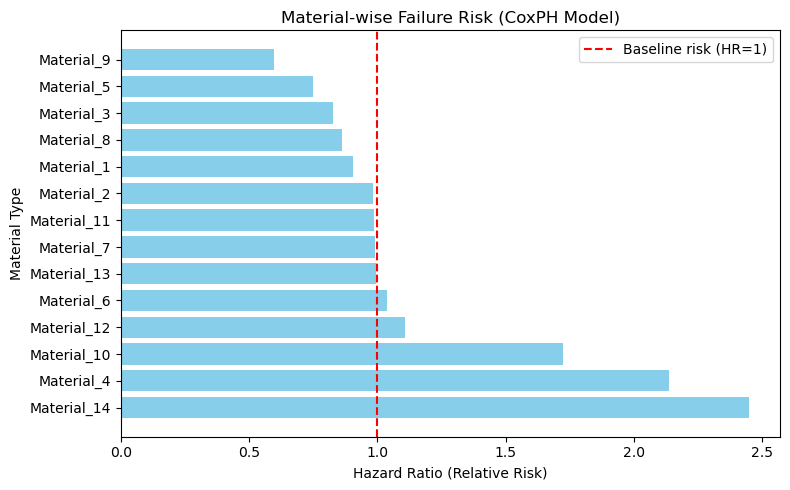

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(hr_sorted["Variable"], hr_sorted["Hazard_Ratio"], color='skyblue')
plt.axvline(x=1, color='red', linestyle='--', label='Baseline risk (HR=1)')
plt.xlabel("Hazard Ratio (Relative Risk)")
plt.ylabel("Material Type")
plt.title("Material-wise Failure Risk (CoxPH Model)")
plt.legend()
plt.tight_layout()
plt.show()



🧪 Checking Proportional Hazards (PH) assumption...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 42493 total observations, 40341 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic      p  -log2(p)
Material_1  km              0.01   0.93      0.10
            rank            0.00   0.95      0.07
Material_10 km              1.43   0.23      2.11
            rank            2.32   0.13      2.97
Material_11 km              0.00   0.99      0.01
            rank            0.00   0.99      0.01
Material_12 km             11.97 <0.005     10.85
            rank           19.16 <0.005     16.35
Material_13 km              0.00   1.00      0.00
            rank            0.00   1.00      0.00
Material_14 km              1.03   0.31      1.69
            rank            5.09   0.02      5.38
Material_2  km              0.00   0.99      0.01
            rank            0.00   0.99      0.02
Material_3  km             31.75 <0.005     25.76
            rank           42.88 <0.005     34.00
Material_4  km              3.99   0.05      4.45
            rank            5.08   0.02      5.37
Material_5  km              0.02   0.90      0.15
            rank            0.01   0.91      0.13
Material_6  km              2.27   0.13      2.92
            rank            4.26   0.04      4.68
Material_7  km              0.00   0.98      0.03
            rank            0.00   0.97      0.04
Material_8  km              0.02   0.88      0.19
            rank            0.01   0.94      0.09
Material_9  km              0.00   0.95      0.08
            rank            0.00   0.95      0.07



1. Variable 'Material_3' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Material_3', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Material_4' failed the non-proportional test: p-value is 0.0242.

   Advice: with so few unique values (only 2), you can include `strata=['Material_4', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


3. Variable 'Material_6' failed the non-proportional test: p-value is 0.0390.

   Advice: with so few unique values (only 2), you can include `strata=['Material_6', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. M

[[<Axes: xlabel='rank-transformed time\n(p=0.9541)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9332)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9870)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9897)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0242)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0457)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9111)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8982)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0390)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1323)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9719)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9783)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9389)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8787)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9546)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9457)'>],
 [<Axes: xlabel='rank-transformed tim

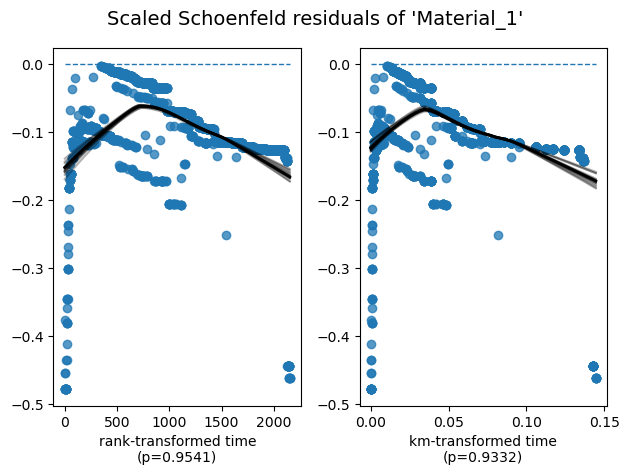

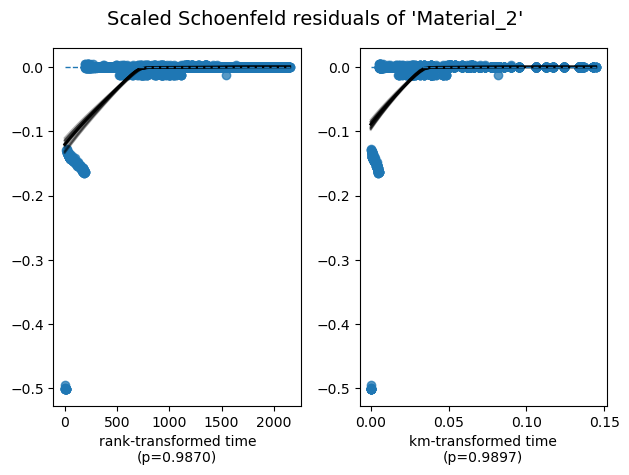

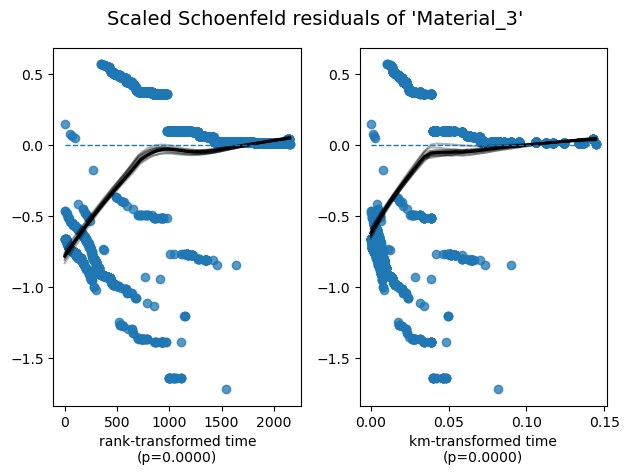

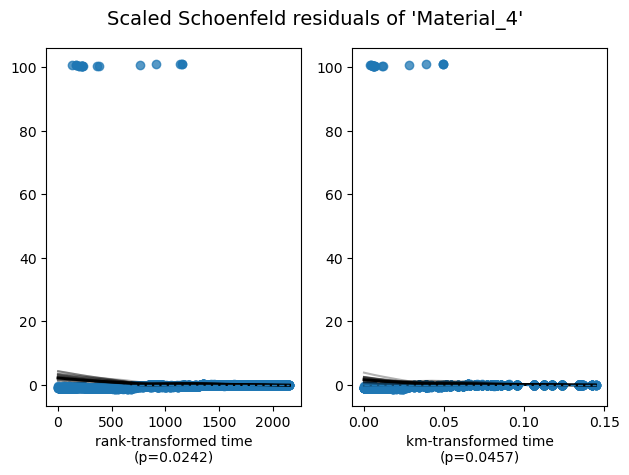

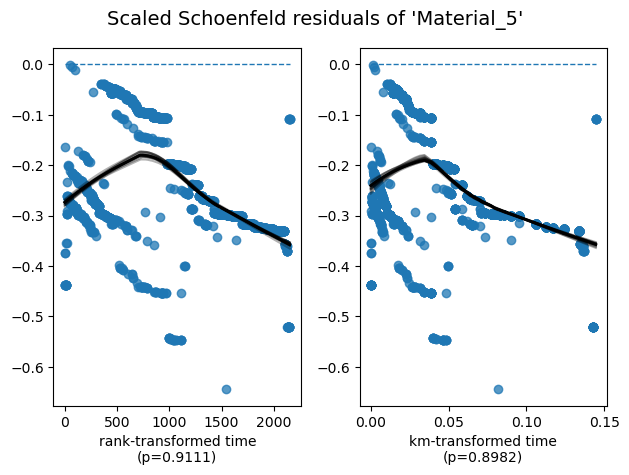

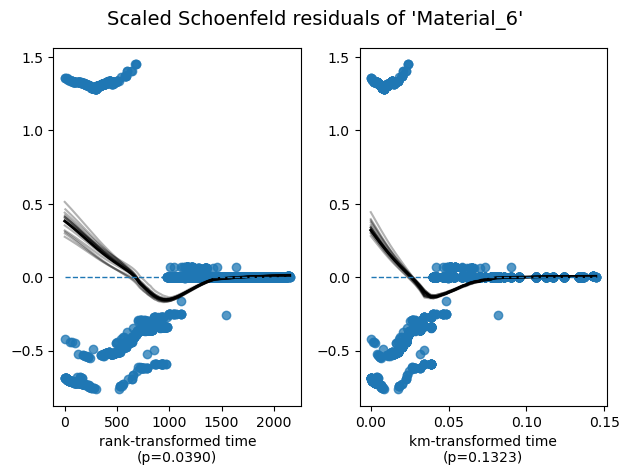

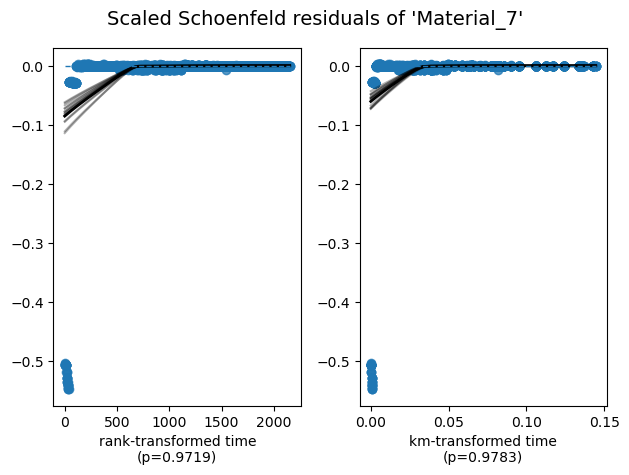

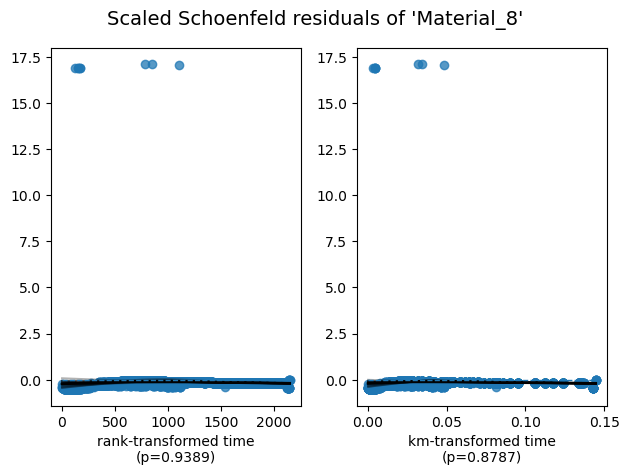

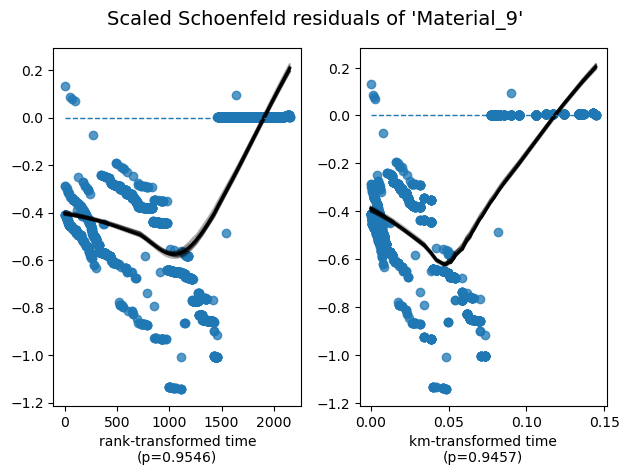

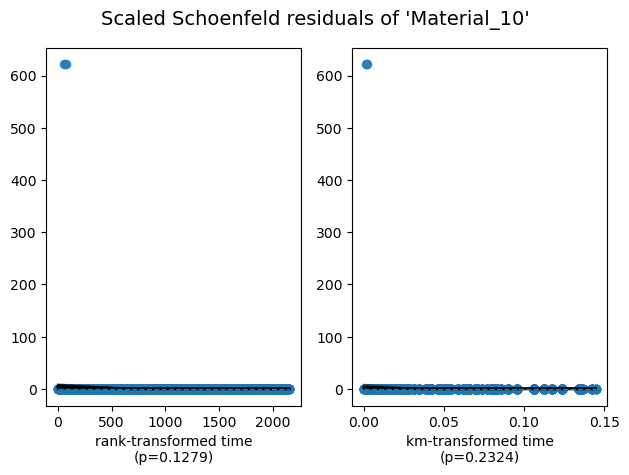

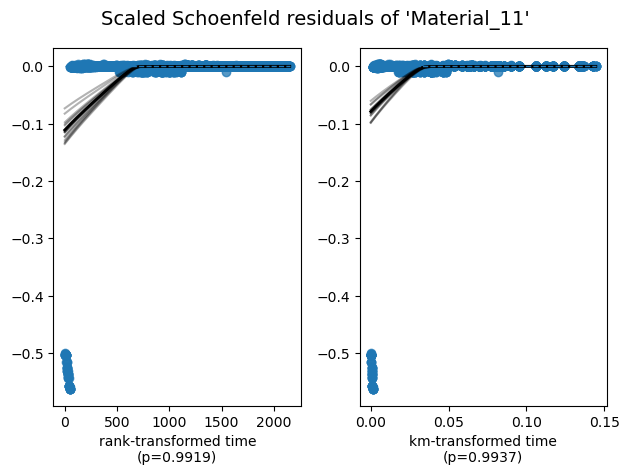

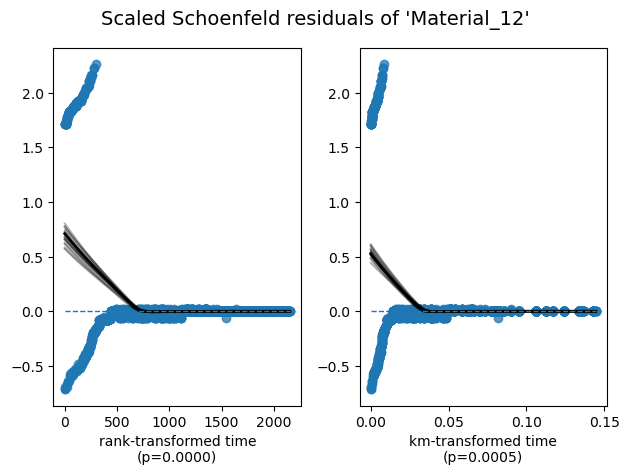

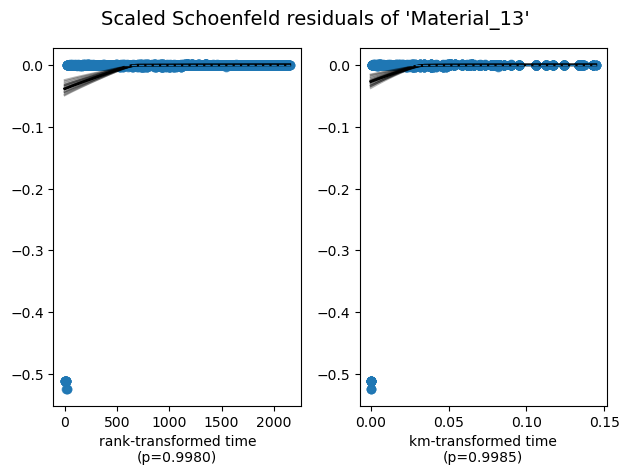

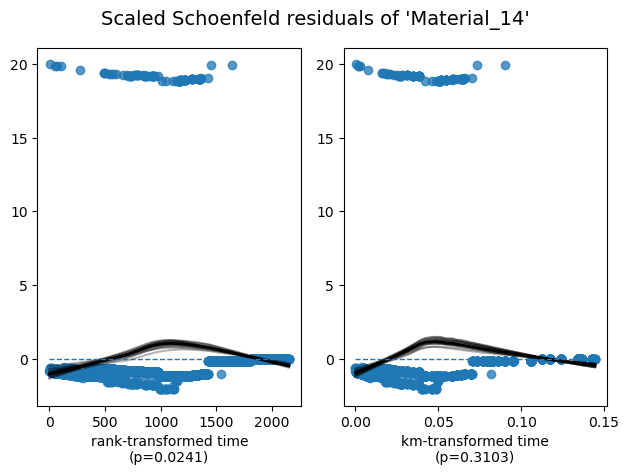

In [15]:
# ✅ Check proportional hazards assumption
print("\n🧪 Checking Proportional Hazards (PH) assumption...\n")

# If cph model already fitted as 'cph'
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=True)


→ যদি p-value > 0.05, তাহলে ✅ assumption ঠিক আছে।
→ যদি p-value < 0.05, তাহলে ⚠️ কিছু covariate time-dependent হতে পারে।

In [17]:
# ✅ Step 1: Prepare Cox model (if not fitted yet)

from lifelines import CoxPHFitter
import pandas as pd
import numpy as np

cox_df = df[['Duration_years', 'Event', 'Material', 'Diameter', 'Length', 'BreakAge']].copy()
cox_df = pd.get_dummies(cox_df, columns=['Material'], drop_first=True)
cox_df = cox_df.dropna()
cox_df = cox_df[cox_df['Duration_years'] > 0]

cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col='Duration_years', event_col='Event')
cph.print_summary()


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

✅ Step 2: Predict failure risk for each pipe

Cox model hazard ratio বলতে গেলে relative failure risk দেয়।
আমরা প্রতিটি pipe-এর জন্য partial hazard (risk score) বের করবো 👇

In [ ]:
# Predict relative hazard (risk score)
cox_df['Predicted_Risk'] = cph.predict_partial_hazard(cox_df)

# Attach pipe IDs back
cox_df['ID'] = df.loc[cox_df.index, 'ID']

# Sort descending — higher risk first
risk_ranked = cox_df.sort_values('Predicted_Risk', ascending=False)
risk_ranked.to_csv("Predicted_High_Risk_Pipes.csv", index=False)

print("\n🔹 Top 10 High-Risk Pipes:")
print(risk_ranked[['ID', 'Predicted_Risk']].head(10))


✅ Step 3: Define high-risk percentiles (5%, 10%, 15%, 20%)

percentiles = [5, 10, 15, 20]
results = []

total = len(risk_ranked)
future_fail_ids = set(future_fail['ID'])  # from data2 (actual future failures)

for p in percentiles:
    top_n = int(total * (p / 100))
    top_risky_ids = set(risk_ranked.head(top_n)['ID'])
    
    matches = top_risky_ids.intersection(future_fail_ids)
    
    results.append({
        "Top %": f"{p}%",
        "Pipes Predicted High-Risk": top_n,
        "Actually Failed (after 2018)": len(matches),
        "Match Rate (%)": round(len(matches) / top_n * 100, 2)
    })

summary = pd.DataFrame(results)
print("\n📊 Temporal Validation Summary (Future Failures):")
print(summary)


✅ Step 4: Visualization (optional for journal)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(summary["Top %"], summary["Match Rate (%)"], marker='o', linewidth=2)
plt.title("Model Validation — High-Risk Pipes vs Actual Failures")
plt.xlabel("Top Percentile (Predicted High-Risk)")
plt.ylabel("Match Rate (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


💡 Optional (future-probability version)

যদি তুমি risk না, বরং specific time horizon (e.g., next 5 years) এ failure probability চাও, তাহলে Cox model এর survival function ব্যবহার করো ⤵️

In [ ]:
# Predict probability of failure within 5 years
T = 5.0
surv_T = cph.predict_survival_function(cox_df, times=[T]).loc[T]
cox_df['Prob_Fail_within_5yr'] = 1 - surv_T


In [ ]:
cox_df[['ID', 'Prob_Fail_within_5yr']].sort_values('Prob_Fail_within_5yr', ascending=False).head(10)
